In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from Preprocessingfunctions import convertclock,OutlierDetection, ShotQualifier
import statsmodels.api as spearman
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from matplotlib import cm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle

shotlogs=pd.read_csv('shot_logs.csv')
shotlogs.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [2]:
shotlogs['GAME_CLOCK']=shotlogs['GAME_CLOCK'].apply(convertclock)
shotlogs['GAME_CLOCK']=pd.to_numeric(shotlogs['GAME_CLOCK'], errors='coerce')
shotlogs['SHOT_CLOCK']=shotlogs['SHOT_CLOCK'].fillna(shotlogs['GAME_CLOCK'])
shotlogs['SHOT_CLOCK']=pd.to_numeric(shotlogs['SHOT_CLOCK'], errors='coerce')

shotlogs['PTS_TYPE']=shotlogs['SHOT_DIST'].apply(lambda x: 3 if x >= 23 else 2)

In [3]:
shotlogs['LOCATION']=np.where(shotlogs['LOCATION']=='A',0,1)
shotlogs['W']=np.where(shotlogs['W']=='W',1,0)
shotlogs['SHOT_RESULT']=np.where(shotlogs['SHOT_RESULT']=='made',1,0)

In [4]:
OutlierDetection(shotlogs[['SHOT_DIST','TOUCH_TIME','CLOSE_DEF_DIST']])

/Users/michaelgriffin/TensorFlowProject/TensorFlow-First-Project/Functions/Preprocessingfunctions.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df=clean_df[mask]


,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST
0,7.7,1.9,1.3
1,28.2,0.8,6.1
2,10.1,2.7,0.9
3,17.2,1.9,3.4
4,3.7,2.7,1.1
...,...,...,...
128064,8.7,6.2,0.8
128065,0.6,5.2,0.6
128066,16.9,4.2,4.2
128067,18.3,4.5,3.0


In [5]:
shotlogs[['Date','Matchup']]=shotlogs['MATCHUP'].str.split('-', expand=True)

In [6]:
shotlogs[['Away Team','Home Team']]=shotlogs['Matchup'].str.split('@', expand=True)

In [7]:
final_shotlog=shotlogs.drop(['MATCHUP'],axis=1)

In [8]:
final_shotlog['Date']=pd.to_datetime(final_shotlog['Date'], format='%b %d, %Y ')


In [9]:
final_shotlog['Player_Team']=final_shotlog.apply(lambda row: row['Away Team'] if ['LOCATION'] == 'A' else row['Home Team'], axis=1)  

In [10]:
EFG_CALC=final_shotlog[['player_name','player_id','SHOT_RESULT','PTS']].copy(deep=True)
DEFG_CALC=final_shotlog[['CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','SHOT_RESULT','PTS']].copy(deep=True)

In [11]:
total_attempts=EFG_CALC['player_name'].value_counts()
makes=EFG_CALC.groupby(['player_name'])['PTS'].value_counts()
two_pt_makes=makes.xs(2,level='PTS')
three_pt_makes=makes.xs(3, level='PTS')

efg=pd.DataFrame({
    'Total Attempts':total_attempts,
    'Two Point Makes':two_pt_makes,
    'Three Point Makes':three_pt_makes
})

total_attempts=DEFG_CALC['CLOSEST_DEFENDER'].value_counts()
makes=DEFG_CALC.groupby(['CLOSEST_DEFENDER'])['PTS'].value_counts()
two_pt_makes=makes.xs(2,level='PTS')
three_pt_makes=makes.xs(3, level='PTS')

defg=pd.DataFrame({
    'Total Attempts':total_attempts,
    'Two Point Makes':two_pt_makes,
    'Three Point Makes':three_pt_makes
})



In [12]:
efg['EFG']= ((efg['Two Point Makes']+efg['Three Point Makes'])+(0.5*efg['Three Point Makes']))/efg['Total Attempts']
efg=efg.drop(['Total Attempts','Two Point Makes','Three Point Makes'],axis=1)



defg['DEFG']= ((defg['Two Point Makes']+defg['Three Point Makes'])+(0.5*defg['Three Point Makes']))/defg['Total Attempts']
defg=defg.drop(['Total Attempts','Two Point Makes','Three Point Makes'],axis=1)

In [13]:
final_shotlog['EFG']=final_shotlog['player_name'].map(efg['EFG'])
final_shotlog['DEFG']=final_shotlog['CLOSEST_DEFENDER'].map(defg['DEFG'])

Binning shots into categories based on distance and defensive factors

Binning based upon distance from basket

In [14]:
bins=[0, 1, 4, 18, 23, 35, 100]
labels=['Dunk','Layup','Midrange','Long Two','Three Pointer','Long Three']
final_shotlog['Shot Bins']=pd.cut(final_shotlog['SHOT_DIST'],bins=bins, labels=labels)

Binning based in defender proximity

In [15]:
bins=[0, 2, 6, 10, 40]
labels=['Smothered','Contested','Open','Left Alone']
final_shotlog['Openness']=pd.cut(final_shotlog['CLOSE_DEF_DIST'],bins=bins, labels=labels)

In [16]:
print(final_shotlog.describe())

            GAME_ID       LOCATION              W   FINAL_MARGIN  \
count  1.280690e+05  128069.000000  128069.000000  128069.000000   
mean   2.140045e+07       0.499215       0.504377       0.208723   
min    2.140000e+07       0.000000       0.000000     -53.000000   
25%    2.140023e+07       0.000000       0.000000      -8.000000   
50%    2.140045e+07       0.000000       1.000000       1.000000   
75%    2.140067e+07       1.000000       1.000000       9.000000   
max    2.140091e+07       1.000000       1.000000      53.000000   
std    2.578773e+02       0.500001       0.499983      13.233267   

         SHOT_NUMBER         PERIOD     GAME_CLOCK     SHOT_CLOCK  \
count  128069.000000  128069.000000  128069.000000  128069.000000   
mean        6.506899       2.469427     351.393811      17.932493   
min         1.000000       1.000000       0.000000       0.000000   
25%         3.000000       1.000000     172.000000       8.000000   
50%         5.000000       2.000000     35

/var/folders/2x/nf0lp8t90h3dqk26_6q9tztr0000gn/T/ipykernel_21172/2971430814.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_shotlog.groupby('Shot Bins')['SHOT_RESULT'].mean().plot.bar()


<Axes: xlabel='Shot Bins'>

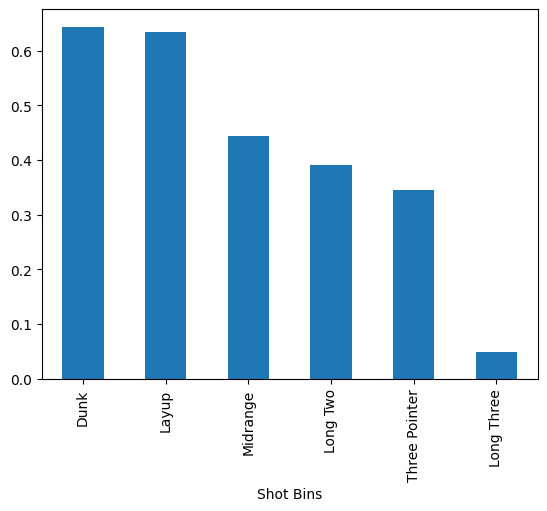

In [17]:
final_shotlog.groupby('Shot Bins')['SHOT_RESULT'].mean().plot.bar()

/var/folders/2x/nf0lp8t90h3dqk26_6q9tztr0000gn/T/ipykernel_21172/403898471.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_shotlog.groupby('Openness')['SHOT_RESULT'].mean().plot.bar()


<Axes: xlabel='Openness'>

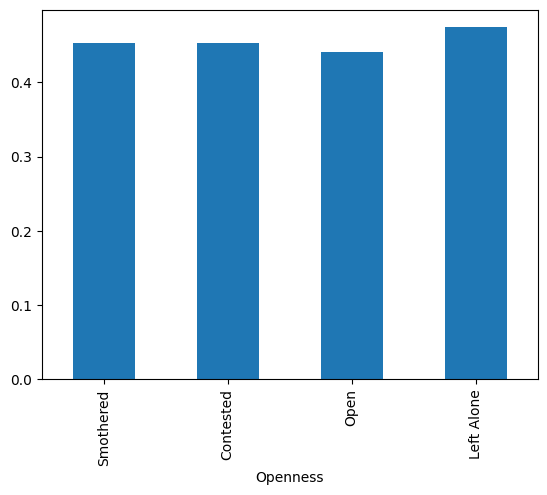

In [18]:
final_shotlog.groupby('Openness')['SHOT_RESULT'].mean().plot.bar()

Use a mask to simulate Effective Field Goal%, a better metric for shot value.

/var/folders/2x/nf0lp8t90h3dqk26_6q9tztr0000gn/T/ipykernel_21172/3260335112.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean=final_shotlog.groupby(['Shot Bins', 'Openness'])['SHOT_RESULT'].transform('mean')


Text(0.5, 1.0, 'Field goal percentages by shot type')

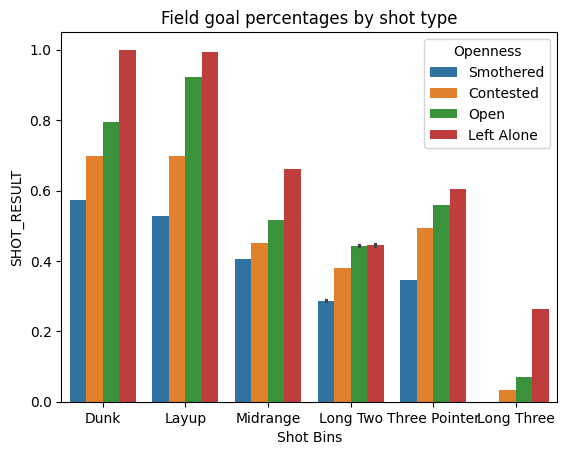

In [19]:
mean=final_shotlog.groupby(['Shot Bins', 'Openness'])['SHOT_RESULT'].transform('mean')
threepointers=final_shotlog['PTS_TYPE']==3
mean[threepointers] += 0.5 * mean[threepointers]
sns.barplot(data=final_shotlog, x='Shot Bins',y=mean, hue='Openness')
plt.title('Field goal percentages by shot type')


Use ShotQualifier function to separate shots, based upon FG% for each type of shot.

In [20]:
final_shotlog['Shot Quality']=final_shotlog.apply(ShotQualifier, axis=1)


In [21]:
final_shotlog.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,Date,Matchup,Away Team,Home Team,Player_Team,EFG,DEFG,Shot Bins,Openness,Shot Quality
0,21400899,0,1,24,1,1,69,10.8,2,1.9,...,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.466398,0.519582,Midrange,Smothered,Low Quality Shot
1,21400899,0,1,24,2,1,14,3.4,0,0.8,...,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.466398,0.479687,Three Pointer,Open,Decent Quality Shot
2,21400899,0,1,24,3,1,0,0.0,3,2.7,...,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.466398,0.479687,Midrange,Smothered,Low Quality Shot
3,21400899,0,1,24,4,2,707,10.3,2,1.9,...,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.466398,0.530000,Midrange,Contested,Low Quality Shot
4,21400899,0,1,24,5,2,634,10.9,2,2.7,...,2015-03-04,CHA @ BKN,CHA,BKN,BKN,0.466398,0.521617,Layup,Smothered,Low Quality Shot


In [22]:
reducedone=final_shotlog[['PERIOD','TOUCH_TIME','PTS_TYPE','DRIBBLES']].copy(deep=True)
scalar=StandardScaler()
pca=PCA(n_components=2)
scaleddf=scalar.fit_transform(reducedone)
pca.fit(scaleddf)
pca_final=pca.transform(scaleddf)
pca_final=pd.DataFrame(pca_final, columns=['PC1','PC2'])
pca_final.head()

,PC1,PC2
0,-0.189508,-1.358276
1,-1.267073,0.064107
2,0.192509,-1.334999
3,-0.131971,-0.667403
4,0.050547,-0.658175


In [23]:
final_shotlog=pd.concat([final_shotlog,pca_final], axis=1)
final_shotlog=final_shotlog.drop(['PERIOD','TOUCH_TIME','DRIBBLES','PTS_TYPE','FGM'],axis=1)


Label Encoding Features

In [24]:
encoder=preprocessing.LabelEncoder()
final_shotlog['Shot Bins']=encoder.fit_transform(final_shotlog['Shot Bins'])
final_shotlog['Openness']=encoder.fit_transform(final_shotlog['Openness'])
final_shotlog['Shot Quality']=encoder.fit_transform(final_shotlog['Shot Quality'])

In [25]:
final_shotlog.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,...,Away Team,Home Team,Player_Team,EFG,DEFG,Shot Bins,Openness,Shot Quality,PC1,PC2
0,21400899,0,1,24,1,69,10.8,7.7,1,"Anderson, Alan",...,CHA,BKN,BKN,0.466398,0.519582,4,3,2,-0.189508,-1.358276
1,21400899,0,1,24,2,14,3.4,28.2,0,"Bogdanovic, Bojan",...,CHA,BKN,BKN,0.466398,0.479687,5,2,0,-1.267073,0.064107
2,21400899,0,1,24,3,0,0.0,10.1,0,"Bogdanovic, Bojan",...,CHA,BKN,BKN,0.466398,0.479687,4,3,2,0.192509,-1.334999
3,21400899,0,1,24,4,707,10.3,17.2,0,"Brown, Markel",...,CHA,BKN,BKN,0.466398,0.530000,4,0,2,-0.131971,-0.667403
4,21400899,0,1,24,5,634,10.9,3.7,0,"Young, Thaddeus",...,CHA,BKN,BKN,0.466398,0.521617,1,3,2,0.050547,-0.658175


In [28]:
Encoder=OneHotEncoder(sparse_output=False)
one_hot=Encoder.fit_transform(final_shotlog[['Shot Quality']])
oh_df=pd.DataFrame(one_hot, columns=Encoder.get_feature_names_out(['Shot Quality']))
final_shotlog=pd.concat([final_shotlog, oh_df], axis=1)
final_shotlog=final_shotlog.drop(['Shot Quality'], axis=1)

In [30]:
final_shotlog.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,...,Shot Bins,Openness,PC1,PC2,Shot Quality_0,Shot Quality_1,Shot Quality_2,Shot Quality_0,Shot Quality_1,Shot Quality_2
0,21400899,0,1,24,1,69,10.8,7.7,1,"Anderson, Alan",...,4,3,-0.189508,-1.358276,0.0,0.0,1.0,0.0,0.0,1.0
1,21400899,0,1,24,2,14,3.4,28.2,0,"Bogdanovic, Bojan",...,5,2,-1.267073,0.064107,1.0,0.0,0.0,1.0,0.0,0.0
2,21400899,0,1,24,3,0,0.0,10.1,0,"Bogdanovic, Bojan",...,4,3,0.192509,-1.334999,0.0,0.0,1.0,0.0,0.0,1.0
3,21400899,0,1,24,4,707,10.3,17.2,0,"Brown, Markel",...,4,0,-0.131971,-0.667403,0.0,0.0,1.0,0.0,0.0,1.0
4,21400899,0,1,24,5,634,10.9,3.7,0,"Young, Thaddeus",...,1,3,0.050547,-0.658175,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
final_shotlog=final_shotlog.loc[:,~final_shotlog.columns.duplicated()].copy()
final_shotlog.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,...,Player_Team,EFG,DEFG,Shot Bins,Openness,PC1,PC2,Shot Quality_0,Shot Quality_1,Shot Quality_2
0,21400899,0,1,24,1,69,10.8,7.7,1,"Anderson, Alan",...,BKN,0.466398,0.519582,4,3,-0.189508,-1.358276,0.0,0.0,1.0
1,21400899,0,1,24,2,14,3.4,28.2,0,"Bogdanovic, Bojan",...,BKN,0.466398,0.479687,5,2,-1.267073,0.064107,1.0,0.0,0.0
2,21400899,0,1,24,3,0,0.0,10.1,0,"Bogdanovic, Bojan",...,BKN,0.466398,0.479687,4,3,0.192509,-1.334999,0.0,0.0,1.0
3,21400899,0,1,24,4,707,10.3,17.2,0,"Brown, Markel",...,BKN,0.466398,0.530000,4,0,-0.131971,-0.667403,0.0,0.0,1.0
4,21400899,0,1,24,5,634,10.9,3.7,0,"Young, Thaddeus",...,BKN,0.466398,0.521617,1,3,0.050547,-0.658175,0.0,0.0,1.0


In [32]:
with open('multi-class.pkl', 'wb') as file:
    pickle.dump(final_shotlog, file)